In [1]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import auxiliar as aux 
from preprocessing import apply_ODE, init_dataset, discretize_columns, scale

# **Ensamble Naive Bayes**

Vamos a realizar un ensamble con los siguientes modelos: 

    - GuassianNB: para las columnas numéricas
    - CategoricalNB: para las columnas categóricas

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categóricos:

In [2]:
X,y = aux.get_train_set()
X = init_dataset(X)

## Gaussian Naive Bayes

Para aplicar este tipo de modelo debemos quedarnos solo con las columnas continuas. En este caso no nos hace falta aplicar OHE, puesto que todas las columnas que nos quedan son numéricas. Tampoco nos sirve los preprocesamientos de reduccion por frecuencia o discretizacion, puesto que esto eliminaria o generaria nuevas columnas categoricas.

In [3]:
X_continuos = X.select_dtypes(include=['int64','int32'])
X_continuos.head()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas
0,17,39,2174,40
1,17,50,0,13
2,13,38,0,40
3,11,53,0,40
4,17,28,0,40


Ahora realizamos un escalado a nuestras columnas continuas. El rango de escalado es entre (0,1):

In [4]:
X_gauss = scale(X_continuos)
X_gauss

array([[0.84210526, 0.30136986, 0.06257486, 0.39795918],
       [0.84210526, 0.45205479, 0.04174213, 0.12244898],
       [0.63157895, 0.28767123, 0.04174213, 0.39795918],
       ...,
       [0.63157895, 0.56164384, 0.04174213, 0.39795918],
       [0.63157895, 0.06849315, 0.04174213, 0.19387755],
       [0.63157895, 0.47945205, 0.18571223, 0.39795918]])

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X_gauss, y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo gaussiano con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [6]:
parameters = {
    'var_smoothing': np.arange(0, 1e-6, 1e-8)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.836209464438614
Mejores Parametros {'var_smoothing': 9.9e-07}

Mejor score ROC-AUC en Validación: 0.8343866072718269


Armamos el modelo de GaussianNB con los hiperparametros calculados:

In [7]:
model_gaussianNB = gscv.best_estimator_
model_gaussianNB

GaussianNB(var_smoothing=9.9e-07)

Predecimos con el validation set. A diferencia de todos los otros modelos, aqui predecimos la probabilidades de pertenecer a dicha cateogria lo cual nos servira mas adelante cuando querramos realizar el ensamble:

In [8]:
gaussianNB_predict = model_gaussianNB.predict_proba(X_validation)

## Categorical Naive Bayes

Para aplicar este tipo de modelo debemos quedarnos solo con columnas categóricas para luego aplicar Ordinal Encoder (ODE).

In [9]:
X_category = X.select_dtypes(include=['category'])
X_category.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,trabajo
0,palermo,empleado_provincial,sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento
1,palermo,monotributista,matrimonio_civil,hombre,cristianismo,casado,directivo_gerente
2,palermo,relacion_de_dependencia,divorciado,hombre,cristianismo,sin_familia,limpiador
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,judaismo,casado,limpiador
4,balvanera,relacion_de_dependencia,matrimonio_civil,mujer,judaismo,casada,profesional_especializado


Ahora discretizaremos las columnas numéricas y luego aplicaremos ODE a las columnas categóricas:

In [10]:
X_categ = discretize_columns(X)
X_categ = apply_ODE(X_categ)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_categ, y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo categoricalNB con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [12]:
parameters = {
    'alpha': np.arange(0, 1, 0.01),
}

clf = CategoricalNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8934156599185314
Mejores Parametros {'alpha': 0.1}

Mejor score ROC-AUC en Validación: 0.8849950862549266


Armamos el modelo de CategoricalNB con los hiperparámetros calculados:

In [13]:
model_categoricalNB = gscv.best_estimator_
model_categoricalNB

CategoricalNB(alpha=0.1)

Predecimos con el validation set. Similar a como lo hicimos en modelo anterior, aquí predecimos la probabilidades de pertenecer a dicha categoría lo cual nos servira mas adelante cuando querramos realizar el ensamble:

In [14]:
categoricalNB_predict = model_categoricalNB.predict_proba(X_validation)

## Realizando el Ensamble

Para este ensamble optamos por utilizar el método de Voting, el cual recibe las prediciones de los anteriores modelos entrenados y mediante una medida de votación genera la predicción final. Los modelos que utilizamos para realizar el ensamble son los mostrados anteriormente: GaussianNB y CategoricalNB.

Primero generamos la siguiente función **ensamble_predict_proba** la cual recible las probabilidades de ambos modelos y devuleve la predicción final en forma de probabilidades. La lógica de la función es la siguiente: para cada clase, la probabilidad será el promedio de las probabilidades de ambos modelos para esa clase

La predicción final resulta entonces del promedio de las probabilidades entre cada modelo para cada instancia.

In [15]:
def ensamble_predict_proba(gaussianNB_predict, categoricalNB_predict):
    predictions_proba = []
    for x in range(len(gaussianNB_predict)):
        a = (gaussianNB_predict[x, 0] + categoricalNB_predict[x, 0])/2
        b = (gaussianNB_predict[x, 1] + categoricalNB_predict[x, 1])/2
        predictions_proba.append([a, b])
    return predictions_proba

La función **ensamble_predict** nos devolverá la clase con mayor probabilidad para cada instancia, luego de haber promediado las probabilidades de ambos modelos

In [16]:
def ensamble_predict(gaussianNB_predict, categoricalNB_predict):
    predictions = []
    predictions_proba = ensamble_predict_proba(gaussianNB_predict, categoricalNB_predict)
    for prediction in np.array(predictions_proba)[:, 1]:
        if(prediction > 0.5):
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Realizamos la predicción final en base a las predicciones de los anteriores modelos:

In [17]:
ensambleNB_predict = ensamble_predict(gaussianNB_predict, categoricalNB_predict)

**Metricas**

In [18]:
print(classification_report(y_validation, ensambleNB_predict))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4945
           1       0.74      0.46      0.57      1568

    accuracy                           0.83      6513
   macro avg       0.80      0.71      0.73      6513
weighted avg       0.82      0.83      0.82      6513



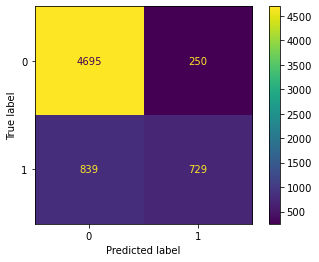

In [19]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_validation,ensambleNB_predict))
cm.plot()

In [20]:
roc_auc = roc_auc_score(y_validation, np.array(ensamble_predict_proba(gaussianNB_predict, categoricalNB_predict))[:, 1])
print(f"\nScore ROC-AUC en Validación: {roc_auc}")


Score ROC-AUC en Validación: 0.8879188290584181


# Conclusión

Vimos que usando únicamente el modelo gaussiano o el modelo categorical no tenemos una muy buena performance en la metrica *roc_auc*. Ahora si juntamos las predicciones de ambos mediante en un ensamble tenemos una mejora de dicha métrica aunque no llega a ser uno de los mejores modelos que tenemos.

# Predicción

Por último, con el ensamble obtenido realizaremos una predicción para datos que nunca vio en el entrenamiento ni en validación.

In [21]:
ids, X_holdout = aux.get_holdout_set()
X_holdout = init_dataset(X_holdout)

In [22]:
X_holdout_continuos = X_holdout.select_dtypes(include=['int64','int32'])

X_holdout_continuos = scale(X_holdout_continuos)
X_holdout_categorical = discretize_columns(X_holdout)
X_holdout_categorical = apply_ODE(X_holdout_categorical)

gaussian_predict = model_gaussianNB.predict_proba(X_holdout_continuos)
categorical_predict = model_categoricalNB.predict_proba(X_holdout_categorical)
ensambleNB_predict = ensamble_predict(gaussian_predict, categorical_predict)

In [23]:
aux.create_prediction(ids, ensambleNB_predict, file_name='ensambleNB')